Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Overview
This notebook generates the estimated affinity values  (and corresponding summary plots) for experimental seeds (Figure 3A) and different walking strategies (Figure 3B).

In [ ]:
import numpy as np
import pandas as pd    
import plotnine as p9

# Parameters used in manuscript

In [ ]:
# Fraction of expected bead coverage from sequencing to consider non-contamination
# For example, a tolerated bead fraction of 0.2 means that if, based on read 
# depth and number of beads, there are 100 reads expected per bead, then 
# sequences with fewer than 20 reads would be excluded from analysis.
TOLERATED_BEAD_FRAC = 0.2 

# Ratio cutoff between positive and negative pools to count as being real.
# The ratio is calculated normalized by read depth, so if the ratio is 0.5, 
# then positive sequences are expected to have equal read depth (or more) in 
# the positive pool as the negative pool. So, as a toy example, if the 
# positive pool had 100 reads total and the negative pool had 200 reads total,
# then a sequence with 5 reads in the positive pool and 10 reads in the 
# negative pool would have a ratio of 0.5.
POS_NEG_RATIO_CUTOFF = 0.5

# Minimum required reads (when 0 it uses only the above filters)
MIN_READ_THRESH = 0

In [ ]:
#@title MLPD Data Parameters
apt_screened_list = [ 3283890.016, 6628573.952, 5801469.696, 3508412.512]
apt_collected_list = [12204, 50353, 153845, 201255]
seq_input = [200000] * 4
conditions = ['round1_very_positive', 
              'round1_high_positive',
              'round1_medium_positive',
              'round1_low_positive']
flags = ['round1_very_flag', 'round1_high_flag', 'round1_medium_flag', 
         'round1_low_flag']
stringency = ['Very High', 'High', 'Medium', 'Low']
mlpd_param_df = pd.DataFrame.from_dict({'apt_screened': apt_screened_list,
                                    'apt_collected': apt_collected_list,
                                    'seq_input': seq_input,
                                    'condition': conditions,
                                    'condition_flag': flags,
                                    'stringency': stringency})


mlpd_param_df

,apt_collected,apt_screened,condition,condition_flag,seq_input,stringency
0,12204,3283890.016,round1_very_positive,round1_very_flag,200000,Very High
1,50353,6628573.952,round1_high_positive,round1_high_flag,200000,High
2,153845,5801469.696,round1_medium_positive,round1_medium_flag,200000,Medium
3,201255,3508412.512,round1_low_positive,round1_low_flag,200000,Low


# Load in Data

In [ ]:
# MLPD sequences with stringency / Kd
# Upload mlpd_input_data_manuscript.csv
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
with open('mlpd_input_data_manuscript.csv') as f:
  mlpd_df = pd.read_csv(f)

# Helper functions

In [ ]:
def generate_cutoffs_via_PD_stats(df, col, apt_screened, apt_collected, seq_input,
                                  tolerated_bead_frac, min_read_thresh):
  """Use the experimental parameters to determine sequences passing thresholds.

  Args:
    df: Pandas dataframe with experiment results. Must have columns named 
      after the col function parameter, containing the read count, and a
      column 'sequence'.
    col: The string name of the column in the experiment dataframe with the 
      read count.
    apt_screened: The integer number of aptamers screened, from the experiment 
      parameters.
    apt_collected: The integer number of aptamers collected, from the experiment
      parameters.
    seq_input: The integer number of unique sequences in the sequence library 
      used to construct the aptamer particles.
    tolerated_bead_frac: The float tolerated bead fraction threshold. In other
      words, the sequencing depth required to keep a sequence, in units of
      fractions of a bead based on the average expected read depth per bead. 
    min_read_threshold: The integer minimum number of reads that a sequence
      must have in order not to be filtered.

  Returns:
    Pandas series of the sequences from the dataframe that pass filter.
  """

  expected_bead_coverage =  apt_screened / seq_input
  tolerated_bead_coverage = expected_bead_coverage * tolerated_bead_frac
  bead_full_min_sequence_coverage = (1. / apt_collected) * tolerated_bead_coverage
  col_sum = df[col].sum()
  # Look at sequenced counts calculated observed fraction of pool and raw count.
  seqs = df[((df[col]/col_sum) > bead_full_min_sequence_coverage) & # Pool frac.
            (df[col] > min_read_thresh)   # Raw count
            ].sequence
  return seqs


def generate_pos_neg_normalized_ratio(df, col_prefix):
  """Adds fraction columns to the dataframe with the calculated pos/neg ratio.

  Args:
    df: Pandas dataframe, expected to have columns [col_prefix]_positive and
      [col_prefix]_negative contain read counts for the positive and negative
      selection conditions, respectively.
    col_prefix: String prefix of the columns to use to calculate the ratio. 
      For example 'round1_very_positive'.
  
  Returns:
    The original dataframe with three new columns:
    [col_prefix]_positive_frac contains the fraction of the total positive 
      pool that is this sequence.
    [col_prefix]_negative_frac contains the fraction of the total negative
      pool that is this sequence.
    [col_prefix]_pos_neg_ratio: The read-depth normalized fraction of the 
      sequence that ended in the positive pool.
  """
  col_pos = col_prefix + '_' + 'positive'
  col_neg = col_prefix + '_' + 'negative'
  df[col_pos + '_frac'] = df[col_pos] /  df[col_pos].sum()
  df[col_neg + '_frac'] = df[col_neg] /  df[col_neg].sum()
  df[col_prefix + '_pos_neg_ratio'] = df[col_pos + '_frac'] / (
      df[col_pos + '_frac'] + df[col_neg + '_frac'])
  return df


def build_seq_sets_from_df (input_param_df, input_df, tolerated_bead_frac, 
                            pos_neg_ratio, min_read_thresh):
  """Sets flags for sequences based on whether they clear stringencies.

  This function adds a column 'seq_set' to the input_param_df (one row per
  stringency level of a particle display experiment) containing all the 
  sequences in the experiment that passed that stringency level in the 
  experiment.

  Args:
    input_param_df: Pandas dataframe with experimental parameters. Expected
      to have one row per stringency level in the experiment and 
      columns 'apt_screened', 'apt_collected', 'seq_input', 'condition', and
      'condition_flag'.
    input_df: Pandas dataframe with the experimental results (counts per 
      sequence) for the experiment covered in the input_param_df. Expected
      to have a [col_prefix]_pos_neg_ratio column for each row of the
      input_param_df (i.e. each stringency level).
    tolerated_bead_frac: Float representing the minimum sequence depth, in
      units of expected beads, for a sequence to be used in analysis.
    pos_neg_ratio: The threshold for the pos_neg_ratio column for a sequence
      to be used in the analysis.
    min_read_thresh: The integer minimum number of reads for a sequence to
      be used in the analysis (not normalized, a straight count.)

  Returns:
    Nothing.

  """
  for _, row in input_param_df.iterrows():
    
    # Get parameters to calculate bead fraction.
    apt_screened = row['apt_screened']
    apt_collected = row['apt_collected']
    seq_input = row['seq_input']
    condition = row['condition']
    flag = row['condition_flag']
    
    # Get sequences above tolerated_bead_frac in positive pool.
    tolerated_bead_frac_seqs = generate_cutoffs_via_PD_stats(
        input_df, condition, apt_screened, apt_collected, seq_input, 
        tolerated_bead_frac, min_read_thresh)
    
    # Intersect with seqs > normalized positive sequencing count ratio.
    condition_pre = condition.split('_positive')[0]
    ratio_col = '%s_pos_neg_ratio' % (condition_pre)
    pos_frac_seqs = input_df[input_df[ratio_col] > pos_neg_ratio].sequence
    seqs = set(tolerated_bead_frac_seqs) & set(pos_frac_seqs)
    input_df[flag] = input_df.sequence.isin(set(seqs))

## Affnity Helper Function

In [ ]:
def set_stringency_level_mlpd (row):
  """Returns the highest bin for MLPD.

  Args:
    row: A row from the MLPD experiment results. Expected
      to have columns: 'round1_very_flag', 
      'round1_high_flag', 'round1_medium_flag', 'round1_low_flag' indicating
      whether the sequence has passed the stringency threshold for each of
      those conditions.

  Returns:
    Integer from 0-4 indicating the highest stringency level passed by this
    sequence, or -1 to indicate conflicting information (for example passing
    the high stringency threshold but missing the medium stringency 
    threshold).
  """
  v_flag = row.round1_very_flag
  h_flag = row.round1_high_flag
  m_flag = row.round1_medium_flag
  l_flag = row.round1_low_flag

  if v_flag and h_flag and m_flag and l_flag:
    return 4
  elif h_flag and m_flag and l_flag and not v_flag:
    return 3
  elif m_flag and l_flag and not v_flag and not h_flag:
    return 2
  elif not m_flag and l_flag and not v_flag and not h_flag:
    return 1
  elif not m_flag and not l_flag and not v_flag and not h_flag:
    return 0
  else:
    return -1

## Stacked Bar Plot Helpers

In [ ]:
def make_stacked_boxplot(categories, models, stringency_levels, counts, fractions, y='fraction'):
  """Creates the stacked barplot showing relative enrichment.

  The values of categories, models, stringency_levels, counts, and fractions
  are the parallel lists created using construct_category_fractions_for_stacked_hists.
  Each position in the list represents one segment of the stacked bar chart,
  for example, the sequences that started from random seeds, were walked 
  with the Count model and have stringency_level 3 (=high, Kd < 32nM). 

  Args:
    categories: String list of seed categories, corresponding to the three grey
      shaded areas. These are one of 'Random Seeds', 'Expt. Seeds' and 
      'ML Seeds'.
    models: String list of models used to walk the seeds. These represent the
      bars within each seed category, i.e. 'Random', 'Counts', 'SuperBin',
      'Binned'.
    stringency_levels: Integer list of stringency levels, 0-4, representing
      Kd levels.
    counts: Integer list of the number of sequences in this group of sequences.
    fractions: Float list of the fraction of sequences in this group out of
      the total sequences at all stringency levels. (For example, the fraction
      of sequences from Random Seeds walked by the Counts model that are at
      stringency level 2 as a fraction of all the sequences generated by taking
      Random Seeds and walking them with the Counts model.)
    y: The string name of the column to plot on the y axis.

  Returns:
    p: the ggplot figure
    fishplot_df: The Pandas dataframe with the calculated values.
  """
  fishplot_df = pd.DataFrame.from_dict({'category': categories,
                                      'walking_model': models,
                                      'stringency_level': stringency_levels,
                                      'count': counts, 
                                      'fraction': fractions})
  fishplot_df['log_count'] = np.log2(fishplot_df['count'])
  fishplot_df['log_fraction'] = np.log10(fishplot_df['fraction'])
  fishplot_df['category_cat'] = pd.Categorical(fishplot_df['category'], 
                                      categories=['Random Seeds', 'ML Seeds', 'Expt. Seeds'][::-1], 
                                      ordered=True)
  fishplot_df['model_cat'] = pd.Categorical(fishplot_df['walking_model'], 
                                      categories=['SuperBin',
                                                  'Binned', 
                                                  'Counts', 
                                                  'Random'][::-1], 
                                      ordered=True)
  def stringency_to_kd(val):
    super_bin_to_kd_map = dict(zip(range(5), 
                                 ['> 512nM', '< 512 nM', '< 128 nM', 
                                  '< 32 nM', '< 8 nM']))
    return super_bin_to_kd_map[val]
  
  # For plotting skip the aptamers which did not pass any stringency values
  fishplot_df = fishplot_df[fishplot_df.stringency_level > 0]
  fishplot_df['$K_d$'] = fishplot_df['stringency_level'].apply(stringency_to_kd)
  fishplot_df['$K_d$'] = pd.Categorical(
      fishplot_df['$K_d$'], 
      categories=['< 512 nM', '< 128 nM', '< 32 nM', '< 8 nM'], ordered=True)
  p = (p9.ggplot(fishplot_df, 
                 p9.aes(x='model_cat', y=y, alpha='$K_d$', fill='model_cat'))  + 
       p9.geom_col(position='stack', fill='#32CD32') + p9.coord_flip() + 
       p9.facet_grid(['category_cat', '.']) + 
       p9.theme_minimal() + 
       p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1), 
                figure_size=[5, 5], line=p9.element_line(color='white'))) 

  p = (p9.ggplot(fishplot_df, 
                 p9.aes(x='model_cat', y=y, alpha='$K_d$', fill='model_cat'))  + 
       p9.geom_col(position='stack') + p9.coord_flip() + 
       p9.facet_grid(['category_cat', '.']) + 
       p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1), 
                figure_size=[5, 5], line=p9.element_line(color='white'))  +
       p9.scale_fill_manual(['#202124', '#174ea6', '#e37400', '#681da8', '#018774'][::-1]) +
       p9.ylim([0.0, 0.2])
  )
  return p, fishplot_df

In [ ]:
def construct_category_fractions_for_stacked_hists (
    input_df, col, col_cat, cat_label, groupby_col, base_model,
    categories, models, stringency_levels, counts, fractions, base_models 
    ):
  '''For each subcategory calculate the fraction of data at each Kd.

  This function adds to the parallel lists of categories, models, 
  stringency_levels, counts, fractions, and base_models that are later used
  in creating the stacked bar plots.

  For example, col_cat=['RANDOM_SEEDS_WALKED'], col='sequence_set', 
  col_label='Random Seeds', groupby_col='walking_model', and base_model=None
  would limit the input dataframe of sequences to those sequences where the
  sequence set is 'RANDOM_SEEDS_WALKED' (in other words, the set of sequences
  that started from random sequences and were walked by an ML model). These
  sequences would then by grouped by the walking model column plus the
  stringency level (i.e. 0-4), i.e. the  model used to walk these sequences 
  and the affinity of the resulting sequence. For each group, the results
  would be added to each of these parallel lists. So in this case, the 
  category would always be 'Random Seeds' (since that's the col_label), 
  and the model would be the walking model, and the stringency level would
  be the stringency level of the group. So far this is all basic categories.
  The next lists are the actual values used in plotting. The number of sequences
  in the group gets added to the counts list, and the number of sequences in
  this group relative to all those in this groupby_col is added to the fractions
  list (in other words, what is the  fraction of random seeds walked by the 
  Counts model that ended up at stringency level 2 compared to all the sequences
  generated by walking all random seeds with the Counts model.)

  Args:
    input_df: (pd.DataFrame) Dataframe for grouping.
    cols: (str) Column id to select when subsetting dataframe.
    col_cat: (list) Category within col to match when subsetting.
    cat_label: (str) New label to call category.
    groupby_col: (str) Column idea to group remaining subgroup on.
    base_model: (str or None) Optional base model.  Not currently being used.
    categories: (list) List of categories to append to.
    models: (list) List of models to append to.
    stringency_levels: (list) List of upated_super_bins to append to.
    counts: (list) List of counts to append to.
    fractions: (list) List of fractions to append to.
    base_models: (list) List of base_models to append to.
  '''
  # Select out all unambiguous sequences in this set
  sub_df = input_df[(input_df[col].isin(col_cat)) & 
                    (input_df.stringency_level >= 0)]

  # Create summary stats by stringency level
  for (groupby_cat, stringency), grp in sub_df.groupby([groupby_col, 
                                                       'stringency_level']):
    categories.append(cat_label)
    models.append(groupby_cat)
    stringency_levels.append(stringency)  
    counts.append(len(grp))
    denominator = len(sub_df[(sub_df[col].isin(col_cat)) &
                            (sub_df[groupby_col] == groupby_cat)])
    fractions.append(float(len(grp)) / denominator)
    base_models.append(base_model)


# Convert stringencies to Kd

In [ ]:
#@title Add positive_frac / (positive_frac + negative_frac) col to df

for col_prefix in ['round1_very', 'round1_high', 'round1_medium', 'round1_low']:
  mlpd_df = generate_pos_neg_normalized_ratio(mlpd_df, col_prefix)


In [ ]:
#@title Measure consistency of particle display data when increasing stringency thresholds and set stringeny levels
build_seq_sets_from_df (mlpd_param_df, mlpd_df, 
                        TOLERATED_BEAD_FRAC, 
                        POS_NEG_RATIO_CUTOFF, MIN_READ_THRESH)
mlpd_df['stringency_level'] = mlpd_df.apply(
    lambda x: set_stringency_level_mlpd(x), axis=1)

## Special Handling of 25 sequences ordered at higher multiplicity

The particle display experiment requires a minimum amount of positive material for sequencing to succeed. (Otherwise it's easy to lose the pellet during PCR steps, for example.)

We did not know a priori if we would meet this minimum level from our generated aptamers, therefore we spiked in a set of 25 sequences at higher copy number (400-fold) that were known/expected to be very good aptamers.  Here, we refine affinity estimates for these 25 sequences due to this increase in input copy number.

In [ ]:
# First create 2 dataframes for the 25 and everything else
mlpd_high_count_df = mlpd_df[mlpd_df['multiple_copy_oligo_in_library']].copy()
mlpd_nonhigh_count_df = mlpd_df[~mlpd_df['multiple_copy_oligo_in_library']]

# Confirm that observed high count library is 400 fold greater than rest of library
print "Mean fold increase over library: ", mlpd_high_count_df.library.mean() / mlpd_nonhigh_count_df.library.mean()
print "Median fold increase over library: ", mlpd_high_count_df.library.median() / mlpd_nonhigh_count_df.library.median()

Mean fold increase over library:  356.2413143113234
Median fold increase over library:  405.75


In [ ]:
# Multiply tolerated bead frac by the 400 copies ordered in the library
build_seq_sets_from_df (mlpd_param_df, mlpd_high_count_df, 
                        TOLERATED_BEAD_FRAC*400, 
                        POS_NEG_RATIO_CUTOFF, MIN_READ_THRESH)
mlpd_high_count_df['stringency_level'] = mlpd_high_count_df.apply(
    lambda x: set_stringency_level_mlpd(x), axis=1)
# Join the two sublibraries back together
mlpd_df = pd.concat([mlpd_high_count_df, mlpd_nonhigh_count_df])

## Set stringency levels to rough kd thresholds


In [ ]:
mlpd_stringency_to_kd_map = dict(zip(
    range(-1, 5), 
    ['ambiguous', '> 512nM', '< 512 nM', '< 128 nM', '< 32 nM', '< 8 nM']))

mlpd_df['Kd'] = mlpd_df.stringency_level.apply(
    lambda x: mlpd_stringency_to_kd_map[x])

# Build plot components by adding in walks from random, experimental, and ML seeds 

In [ ]:
categories = []
models = []
stringency_levels = []
counts = []
fractions = []
base_models = []

construct_category_fractions_for_stacked_hists(
    mlpd_df, 'sequence_set', ['RANDOM_SEEDS_WALKED'], 'Random Seeds', 'walking_model', None,
    categories, models, stringency_levels, counts, fractions, base_models)

construct_category_fractions_for_stacked_hists(
    mlpd_df, 'sequence_set', ['EXPT_SEEDS_WALKED'], 'Expt. Seeds', 'walking_model', None,
    categories, models, stringency_levels, counts, fractions, base_models)

construct_category_fractions_for_stacked_hists(
    mlpd_df, 'sequence_set', ['MODEL_INFERENCE_WALKED'], 'ML Seeds', 'walking_model', None,
    categories, models, stringency_levels, counts, fractions, base_models)

# Generate Figure Data/Plots

In [ ]:
# Only 398 of the 400 expt seed sequences were observed in the sequencing data
print 'Total sequences observed in MLPD sequencing : ', mlpd_df[mlpd_df['sequence_set'] == 'EXPT_SEEDS'].Kd.value_counts().sum()

Total sequences observed in MLPD sequencing :  398


In [ ]:
# Extracting remaining 2 seeds from walks and set values to ambiguous (same as conflicting seeds in stringency map)
expt_seeds = mlpd_df[mlpd_df.sequence_set == 'EXPT_SEEDS_WALKED'].seed_seq.unique()
expt_seed_df = pd.DataFrame.from_dict({'sequence': expt_seeds})
mlpd_seed_df = expt_seed_df.merge(mlpd_df, on='sequence', how='left')
mlpd_seed_df['Kd'].fillna('ambiguous', inplace=True)
mlpd_seed_df.Kd.value_counts()

< 512 nM     150
> 512nM      123
< 128 nM     102
ambiguous     13
< 32 nM        8
< 8 nM         4
Name: Kd, dtype: int64

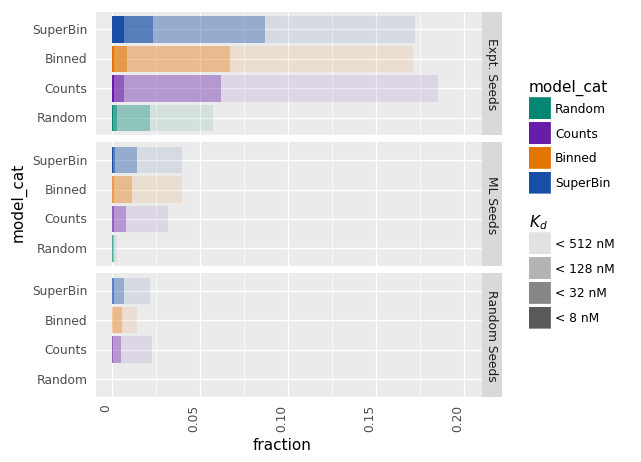

<ggplot: (8787739034497)>

In [ ]:
#3B
p, fishplot_df = make_stacked_boxplot(
    categories, models, stringency_levels, counts, fractions, y='fraction')
p